# Convert and Optimize YOLOv9 with OpenVINO™

YOLOv9 marks a significant advancement in real-time object detection, introducing groundbreaking techniques such as Programmable Gradient Information (PGI) and the Generalized Efficient Layer Aggregation Network (GELAN). This model demonstrates remarkable improvements in efficiency, accuracy, and adaptability, setting new benchmarks on the MS COCO dataset. More details about model can be found in [paper](https://arxiv.org/abs/2402.13616) and [original repository](https://github.com/WongKinYiu/yolov9)
This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch YOLO V9 with OpenVINO.

The tutorial consists of the following steps:

- Prepare PyTorch model
- Convert PyTorch model to OpenVINO IR
- Run model inference with OpenVINO
- Prepare and run optimization pipeline
- Compare performance of the FP32 and quantized models.
- Run optimized model inference on video
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Get PyTorch model](#Get-PyTorch-model)
- [Convert PyTorch model to OpenVINO IR](#Convert-PyTorch-model-to-OpenVINO-IR)
- [Verify model inference](#Verify-model-inference)
    - [Preprocessing](#Preprocessing)
    - [Postprocessing](#Postprocessing)
    - [Select inference device](#Select-inference-device)
- [Optimize model using NNCF Post-training Quantization API](#Optimize-model-using-NNCF-Post-training-Quantization-API)
    - [Prepare dataset](#Prepare-dataset)
    - [Perform model quantization](#Perform-model-quantization)
- [Run quantized model inference](#Run-quantized-model-inference)
- [Compare Performance of the Original and Quantized Models](#Compare-Performance-of-the-Original-and-Quantized-Models)
- [Run Live Object Detection](#Run-Live-Object-Detection)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/yolov9-optimization/yolov9-optimization.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)
## Prerequisites

In [ ]:
%pip install -q "openvino>=2023.3.0" "nncf>=2.8.1" "opencv-python" "matplotlib>=3.4" "seaborn" "pandas" "scikit-learn" "torch" "torchvision" "tqdm"  --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)
from notebook_utils import download_file, VideoPlayer, device_widget

if not Path("yolov9").exists():
    !git clone https://github.com/WongKinYiu/yolov9
%cd yolov9

## Get PyTorch model
[back to top ⬆️](#Table-of-contents:)

Generally, PyTorch models represent an instance of the [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the `gelan-c` (light-weight version of yolov9) model pre-trained on a COCO dataset, which is available in this [repo](https://github.com/WongKinYiu/yolov9), but the same steps are applicable for other models from YOLO V9 family.

In [3]:
# Download pre-trained model weights
MODEL_LINK = "https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt"
DATA_DIR = Path("data/")
MODEL_DIR = Path("model/")
MODEL_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

download_file(MODEL_LINK, directory=MODEL_DIR, show_progress=True)

'model/gelan-c.pt' already exists.


PosixPath('/home/ea/work/openvino_notebooks/notebooks/yolov9-optimization/yolov9/model/gelan-c.pt')

## Convert PyTorch model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports PyTorch model conversion via Model Conversion API. `ov.convert_model` function accepts model object and example input for tracing the model and returns an instance of `ov.Model`, representing this model in OpenVINO format. The Obtained model is ready for loading on specific devices or can be saved on disk for the next deployment using `ov.save_model`.

In [4]:
from models.experimental import attempt_load
import torch
import openvino as ov
from models.yolo import Detect, DualDDetect
from utils.general import yaml_save, yaml_load

weights = MODEL_DIR / "gelan-c.pt"
ov_model_path = MODEL_DIR / weights.name.replace(".pt", "_openvino_model") / weights.name.replace(".pt", ".xml")

if not ov_model_path.exists():
    model = attempt_load(weights, device="cpu", inplace=True, fuse=True)
    metadata = {"stride": int(max(model.stride)), "names": model.names}

    model.eval()
    for k, m in model.named_modules():
        if isinstance(m, (Detect, DualDDetect)):
            m.inplace = False
            m.dynamic = True
            m.export = True

    example_input = torch.zeros((1, 3, 640, 640))
    model(example_input)

    ov_model = ov.convert_model(model, example_input=example_input)

    # specify input and output names for compatibility with yolov9 repo interface
    ov_model.outputs[0].get_tensor().set_names({"output0"})
    ov_model.inputs[0].get_tensor().set_names({"images"})
    ov.save_model(ov_model, ov_model_path)
    # save metadata
    yaml_save(ov_model_path.parent / weights.name.replace(".pt", ".yaml"), metadata)
else:
    metadata = yaml_load(ov_model_path.parent / weights.name.replace(".pt", ".yaml"))

## Verify model inference
[back to top ⬆️](#Table-of-contents:)

To test model work, we create inference pipeline similar to `detect.py`. The pipeline consists of preprocessing step, inference of OpenVINO model, and results post-processing to get bounding boxes.

### Preprocessing
[back to top ⬆️](#Table-of-contents:)

Model input is a tensor with the `[1, 3, 640, 640]` shape in `N, C, H, W` format, where

* `N` - number of images in batch (batch size)
* `C` - image channels
* `H` - image height
* `W` - image width

Model expects images in RGB channels format and normalized in [0, 1] range.
To resize images to fit model size `letterbox` resize approach is used where the aspect ratio of width and height is preserved. It is defined in yolov9 repository.

To keep specific shape, preprocessing automatically enables padding.

In [5]:
import numpy as np
import torch
from PIL import Image
from utils.augmentations import letterbox

image_url = "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/7b6af406-4ccb-4ded-a13d-62b7c0e42e96"
download_file(image_url, directory=DATA_DIR, filename="test_image.jpg", show_progress=True)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv9 input requirements.
    Takes image in np.array format, resizes it to specific size using letterbox resize, converts color space from BGR (default in OpenCV) to RGB and changes data layout from HWC to CHW.

    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
      img0 (np.ndarray): original image
    """
    # resize
    img = letterbox(img0, auto=False)[0]

    # Convert
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img, img0


def prepare_input_tensor(image: np.ndarray):
    """
    Converts preprocessed image to tensor format according to YOLOv9 input requirements.
    Takes image in np.array format with unit8 data in [0, 255] range and converts it to torch.Tensor object with float data in [0, 1] range

    Parameters:
      image (np.ndarray): image for conversion to tensor
    Returns:
      input_tensor (torch.Tensor): float tensor ready to use for YOLOv9 inference
    """
    input_tensor = image.astype(np.float32)  # uint8 to fp16/32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0

    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor


NAMES = metadata["names"]

'data/test_image.jpg' already exists.


### Postprocessing
[back to top ⬆️](#Table-of-contents:)

Model output contains detection boxes candidates. It is a tensor with the `[1,25200,85]` shape in the `B, N, 85` format, where:

- `B` - batch size
- `N` - number of detection boxes

Detection box has the [`x`, `y`, `h`, `w`, `box_score`, `class_no_1`, ..., `class_no_80`] format, where:

- (`x`, `y`) - raw coordinates of box center
- `h`, `w` - raw height and width of box
- `box_score` - confidence of detection box
- `class_no_1`, ..., `class_no_80` - probability distribution over the classes.

For getting final prediction, we need to apply non maximum suppression algorithm and rescale boxes coordinates to original image size.

In [6]:
from utils.plots import Annotator, colors

from typing import List, Tuple
from utils.general import scale_boxes, non_max_suppression


def detect(
    model: ov.Model,
    image_path: Path,
    conf_thres: float = 0.25,
    iou_thres: float = 0.45,
    classes: List[int] = None,
    agnostic_nms: bool = False,
):
    """
    OpenVINO YOLOv9 model inference function. Reads image, preprocess it, runs model inference and postprocess results using NMS.
    Parameters:
        model (Model): OpenVINO compiled model.
        image_path (Path): input image path.
        conf_thres (float, *optional*, 0.25): minimal accepted confidence for object filtering
        iou_thres (float, *optional*, 0.45): minimal overlap score for removing objects duplicates in NMS
        classes (List[int], *optional*, None): labels for prediction filtering, if not provided all predicted labels will be used
        agnostic_nms (bool, *optional*, False): apply class agnostic NMS approach or not
    Returns:
       pred (List): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
       orig_img (np.ndarray): image before preprocessing, can be used for results visualization
       inpjut_shape (Tuple[int]): shape of model input tensor, can be used for output rescaling
    """
    if isinstance(image_path, np.ndarray):
        img = image_path
    else:
        img = np.array(Image.open(image_path))
    preprocessed_img, orig_img = preprocess_image(img)
    input_tensor = prepare_input_tensor(preprocessed_img)
    predictions = torch.from_numpy(model(input_tensor)[0])
    pred = non_max_suppression(predictions, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)
    return pred, orig_img, input_tensor.shape


def draw_boxes(
    predictions: np.ndarray,
    input_shape: Tuple[int],
    image: np.ndarray,
    names: List[str],
):
    """
    Utility function for drawing predicted bounding boxes on image
    Parameters:
        predictions (np.ndarray): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
        image (np.ndarray): image for boxes visualization
        names (List[str]): list of names for each class in dataset
        colors (Dict[str, int]): mapping between class name and drawing color
    Returns:
        image (np.ndarray): box visualization result
    """
    if not len(predictions):
        return image

    annotator = Annotator(image, line_width=1, example=str(names))
    # Rescale boxes from input size to original image size
    predictions[:, :4] = scale_boxes(input_shape[2:], predictions[:, :4], image.shape).round()

    # Write results
    for *xyxy, conf, cls in reversed(predictions):
        label = f"{names[int(cls)]} {conf:.2f}"
        annotator.box_label(xyxy, label, color=colors(int(cls), True))
    return image

In [7]:
core = ov.Core()
# read converted model
ov_model = core.read_model(ov_model_path)

### Select inference device
[back to top ⬆️](#Table-of-contents:)

select device from dropdown list for running inference using OpenVINO

In [8]:
device = device_widget()

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [9]:
# load model on selected device
if device.value != "CPU":
    ov_model.reshape({0: [1, 3, 640, 640]})
compiled_model = core.compile_model(ov_model, device.value)

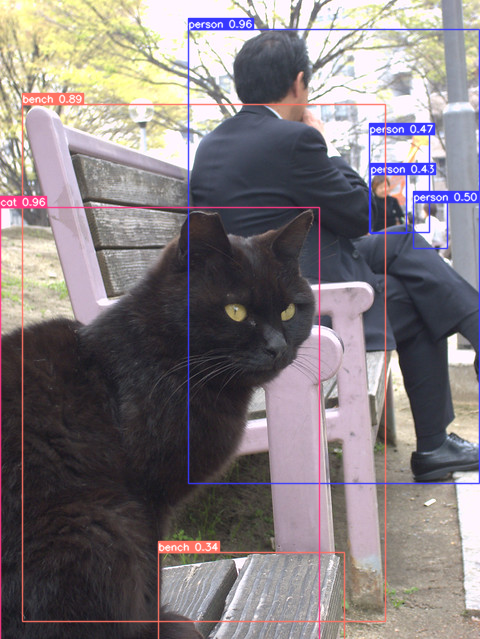

In [10]:
boxes, image, input_shape = detect(compiled_model, DATA_DIR / "test_image.jpg")
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES)
# visualize results
Image.fromarray(image_with_boxes)

## Optimize model using NNCF Post-training Quantization API
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv9.
The optimization process contains the following steps:

1. Create a Dataset for quantization.
2. Run `nncf.quantize` for getting an optimized model.
3. Serialize an OpenVINO IR model, using the `ov.save_model` function.

### Prepare dataset
[back to top ⬆️](#Table-of-contents:)

The code below downloads COCO dataset and prepares a dataloader that is used to evaluate the yolov9 model accuracy. We reuse its subset for quantization.

In [11]:
from zipfile import ZipFile


DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

OUT_DIR = Path(".")

download_file(DATA_URL, directory=OUT_DIR, show_progress=True)
download_file(LABELS_URL, directory=OUT_DIR, show_progress=True)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile("coco2017labels-segments.zip", "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile("val2017.zip", "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / "coco/images")

'val2017.zip' already exists.
'coco2017labels-segments.zip' already exists.


In [12]:
from collections import namedtuple
import yaml
from utils.dataloaders import create_dataloader
from utils.general import colorstr

# read dataset config
DATA_CONFIG = "data/coco.yaml"
with open(DATA_CONFIG) as f:
    data = yaml.load(f, Loader=yaml.SafeLoader)

# Dataloader
TASK = "val"  # path to train/val/test images
Option = namedtuple("Options", ["single_cls"])  # imitation of commandline provided options for single class evaluation
opt = Option(False)
dataloader = create_dataloader(
    str(Path("coco") / data[TASK]),
    640,
    1,
    32,
    opt,
    pad=0.5,
    prefix=colorstr(f"{TASK}: "),
)[0]

val: Scanning coco/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 00:00


NNCF provides `nncf.Dataset` wrapper for using native framework dataloaders in quantization pipeline. Additionally, we specify transform function that will be responsible for preparing input data in model expected format.

In [13]:
import nncf


def transform_fn(data_item):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Tuple with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    img = data_item[0].numpy()
    input_tensor = prepare_input_tensor(img)
    return input_tensor


quantization_dataset = nncf.Dataset(dataloader, transform_fn)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


### Perform model quantization
[back to top ⬆️](#Table-of-contents:)

The `nncf.quantize` function provides an interface for model quantization. It requires an instance of the OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for the configuration quantization process (number of samples for quantization, preset, ignored scope etc.) can be provided.
YOLOv9 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achieve better results, we will use a `mixed` quantization preset.
It provides symmetric quantization of weights and asymmetric quantization of activations.

In [14]:
ov_int8_model_path = MODEL_DIR / weights.name.replace(".pt", "_int8_openvino_model") / weights.name.replace(".pt", "_int8.xml")

if not ov_int8_model_path.exists():
    quantized_model = nncf.quantize(ov_model, quantization_dataset, preset=nncf.QuantizationPreset.MIXED)

    ov.save_model(quantized_model, ov_int8_model_path)
    yaml_save(ov_int8_model_path.parent / weights.name.replace(".pt", "_int8.yaml"), metadata)

## Run quantized model inference
[back to top ⬆️](#Table-of-contents:)

There are no changes in model usage after applying quantization. Let's check the model work on the previously used image. 

In [15]:
quantized_model = core.read_model(ov_int8_model_path)

if device.value != "CPU":
    quantized_model.reshape({0: [1, 3, 640, 640]})

compiled_model = core.compile_model(quantized_model, device.value)

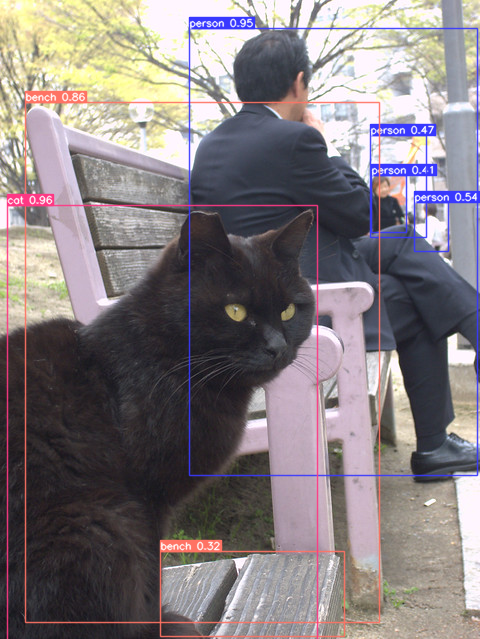

In [16]:
boxes, image, input_shape = detect(compiled_model, DATA_DIR / "test_image.jpg")
image_with_boxes = draw_boxes(boxes[0], input_shape, image, NAMES)
# visualize results
Image.fromarray(image_with_boxes)

## Compare Performance of the Original and Quantized Models
[back to top ⬆️](#Table-of-contents:)

We use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html) to measure the inference performance of the `FP32` and `INT8` models.

> **NOTE**: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [17]:
!benchmark_app -m $ov_model_path -shape "[1,3,640,640]" -d $device.value -api async -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 34.88 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: __module.model.22/aten::cat/Concat_5) : f32 / [...] / [?,84,8400]
[ INFO ]     xi.1 (node: __module.model.22/aten::cat/Concat_2) : f32 / [...] / [?,144,4.

In [18]:
!benchmark_app -m $ov_int8_model_path -shape "[1,3,640,640]" -d $device.value -api async -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2024.0.0-14509-34caeefd078-releases/2024/0
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 74.87 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     images (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     output0 (node: __module.model.22/aten::cat/Concat_5) : f32 / [...] / [?,84,8400]
[ INFO ]     xi.1 (node: __module.model.22/aten::cat/Concat_2) : f32 / [...] / [?,144,4.

## Run Live Object Detection
[back to top ⬆️](#Table-of-contents:)

In [19]:
import collections
import time
from IPython import display
import cv2


# Main processing function to run object detection.
def run_object_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=ov_model,
    device=device.value,
):
    player = None
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)

            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections, _, input_shape = detect(compiled_model, input_image[:, :, ::-1])
            stop_time = time.time()

            image_with_boxes = draw_boxes(detections[0], input_shape, input_image, NAMES)
            frame = image_with_boxes

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.⬆️
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

Use a webcam as the video input. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`.

>**NOTE**: To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a remote server (for example, in Binder or Google Colab service), the webcam will not work. By default, the lower cell will run model inference on a video file. If you want to try live inference on your webcam set `WEBCAM_INFERENCE = True`

Run the object detection:

In [20]:
WEBCAM_INFERENCE = False

if WEBCAM_INFERENCE:
    VIDEO_SOURCE = 0  # Webcam
else:
    VIDEO_SOURCE = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4"

In [21]:
device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [ ]:
quantized_model = core.read_model(ov_int8_model_path)

run_object_detection(
    source=VIDEO_SOURCE,
    flip=True,
    use_popup=False,
    model=quantized_model,
    device=device.value,
)